# Part 2: Implementing a simple Convolutional classifier

**Question 7**: Use the dataloaders to load both the train and the test set into large tensors:
one for the instances, one for the labels. Split the training data into 50 000 training instances
and 10 000 validation instances. Then write a training loop that loops over batches of 16
instances at a time.

Notes:

● Note that the range() function in python can be called with three arguments, to iterate
in large steps.

● It's useful to know that the slice syntax is forgiving if the second argument is out of
bounds. If you have an array with 32 elements then arr[30:36], will just give you
the last two elements without complaining.

● If you have a GPU, make sure not to load these data tensors into GPU memory. It's
better to load each batch into the GPU memory as you loop over the data

We'll use the following network:


| Input size | Layer / Operation | 
:----------:|:-----------------:|
| (batch, 1, 28, 28) | nn.Conv2d | 
| | kernel size 3x3, stride 1, padding 1, 16 output channels | 
| (batch, 16, 28, 28) | ReLU | 
| (batch, 16, 28, 28) | 2x2 Max pool | 
| (batch, 16, 14, 14) | nn.Conv2D | 
| | kernel size 3x3, stride 1, padding 1, 32 output channels |
| (batch, 32, 14, 14) | ReLU | 
| (batch, 32, 14, 14) | 2x2 Max pool |
| (batch, 32, 7, 7) | nn.Conv2D |
| | kernel size 3x3, stride 1, padding 1, 64 output channels |
| (batch, 64, 7, 7) | ReLU |
| (batch, 64, 7, 7) | 2x2 Max pool |
| (batch, 64, 3, 3) | Reshape to flatten the image |
| (batch, 64 * 3 * 3) | Linear layer | 
| (batch, 10) | |


Use cross-entropy as the loss function, and Adam as the optimizer. Most of this was covered
in the PyTorch 60 minute blitz.

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision import transforms




BATCH_SIZE = 64
EPOCHS = 10

train = datasets.MNIST('MNIST_data/',
                       download=True,
                       train=True,
                       transform=ToTensor())
# trainloader = torch.utils.data.DataLoader(train, 
#                                           batch_size=BATCH_SIZE, 
#                                           shuffle=True,
#                                           num_workers=2)

test = datasets.MNIST('MNIST_data/',
                    download=True,
                    train=False,
                    transform=ToTensor())

# testloader = torch.utils.data.DataLoader(test,
#                                         batch_size=BATCH_SIZE,
#                                         shuffle=True,
#                                         num_workers=2)

# CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:

def q7(train_data: torch.utils.data.Dataset, test_data: torch.utils.data.Dataset):
    
    

    # Split the training data into training and validation sets
    train_data, val_data = random_split(train_data, [50000, 10000])

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=2)
    return train_loader, val_loader, test_loader



def training_loop(n_epochs: int,
                 optimizer: torch.optim.Optimizer,
                 model: torch.nn.Module,
                 loss_function: torch.nn.Module,
                 train_loader: torch.utils.data.DataLoader,
                 val_loader: torch.utils.data.DataLoader,
                 device: torch.device):
    print(f'{str("*"*10)}STARTING TRAINING{str("*"*10)}')
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    model = model.to(device)
    loss_function = loss_function.to(device)
    
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs} \n {'-'*30}")
        
        running_acc = 0.0
        running_loss = 0.0
        total_samples = 0
        model.train()
        for batch, (images, labels) in enumerate(train_loader):
            # images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = loss_function(output, labels)
            running_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accuracy training
            running_acc += (output.argmax(1) == labels).sum().item()
            total_samples += labels.shape[0]

            if batch % 500 == 0:
                loss, current = loss.item(), batch * len(images)
                print(f"Loss: {loss:>7f}  [{current:>5d}/{len(train_loader.dataset):>5d}]")


        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / total_samples
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc*100:.2f}%")

        running_acc = 0.0
        running_loss = 0.0
        total_samples = 0
        print(f"{'*'*10} Evaluation {'*'*10}")
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                # images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = loss_function(output, labels)

                running_loss += loss.item()
                running_acc += (output.argmax(1) == labels).sum().item()
                total_samples += labels.shape[0]

            epoch_loss = running_loss / len(val_loader)
            epoch_acc = running_acc / total_samples
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)
            print(f" AVG Val Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_acc*100:.2f}%")
            print()

    print("Finished Training")

    return (train_loss, val_loss, train_acc, val_acc)



**Question 8**: Build this network and tune the hyperparameters until you get a good baseline
performance you are happy with. You should be able to get at least 95% accuracy. If training
takes too long, you can reduce the number of channels in each layer.
In the lectures, we briefly discussed the idea of data augmentation. This is easily added to
our network.

In [9]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_layer = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = self.linear_layer(x)
        return x

In [4]:
model = ConvNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
print(model)


data = q7(train, test)

(train_loader,
val_loader,
test_loader) = data

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)


In [5]:
results = training_loop(EPOCHS, optimizer, model, criterion, train_loader, val_loader, device)

**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.299684  [    0/50000]
Loss: 0.073445  [ 8000/50000]
Loss: 0.031385  [16000/50000]
Loss: 0.174928  [24000/50000]
Loss: 0.054426  [32000/50000]
Loss: 0.000526  [40000/50000]
Loss: 0.011193  [48000/50000]
Training Loss: 0.1563, Training Accuracy: 95.00%
********** Evaluation **********
 AVG Val Loss: 0.0626, Validation Accuracy: 98.02%

Epoch 2/10 
 ------------------------------
Loss: 0.001052  [    0/50000]
Loss: 0.034995  [ 8000/50000]
Loss: 0.002832  [16000/50000]
Loss: 0.008439  [24000/50000]
Loss: 0.025567  [32000/50000]
Loss: 0.244394  [40000/50000]
Loss: 0.000273  [48000/50000]
Training Loss: 0.0501, Training Accuracy: 98.41%
********** Evaluation **********
 AVG Val Loss: 0.0484, Validation Accuracy: 98.54%

Epoch 3/10 
 ------------------------------
Loss: 0.000681  [    0/50000]
Loss: 0.033655  [ 8000/50000]
Loss: 0.002450  [16000/50000]
Loss: 0.080712  [24000/50000]
Loss: 0.003657  [32000

In [4]:
def test(model: nn.Module,
        loss_function: nn.Module,
        test_loader: torch.utils.data.DataLoader,
        device: torch.device):
        
    running_acc = 0.0
    running_loss = 0.0
    total_samples = 0
    print(f"{'*'*10} Testing {'*'*10}")
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            # images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = loss_function(output, labels)

            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels).sum().item()
            total_samples += labels.shape[0]

        loss_ = running_loss / len(test_loader)
        acc = running_acc / total_samples

        print(f" AVG Test Loss: {loss_:.4f}, Test Accuracy: {acc*100:.2f}%")


In [7]:
test(model, criterion, test_loader, device)

********** Testing **********
 AVG Test Loss: 0.0371, Test Accuracy: 99.05%


In [5]:
import matplotlib.pyplot as plt
import numpy as np
# FIRST TRY

def plot_results(results: tuple, save_fig_name: str = None, save: bool = False) -> None:
    ''' 
    Plots the training and validation loss and accuracy for a given model.
    Args:
        results: A tuple containing the training loss, validation loss, training accuracy, and validation accuracy
        save_fig_name: The name of the figure to save. Default is None.
        save: Whether or not to save the figure. Default is False.
    '''

    
    # results = [item.to('cpu') for item in results]
    (train_loss, val_loss, train_acc, val_acc) = results

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    epochs = np.arange(1, EPOCHS+1)

    axs[0].plot(train_loss, label='Training Loss')
    axs[0].plot(val_loss, label='Validation Loss')
    axs[0].set_xticks(epochs)
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(train_acc, label='Training Accuracy')
    axs[1].plot(val_acc, label='Validation Accuracy')
    axs[1].set_xticks(epochs)
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    if save:
        assert save_fig_name is not None, "Please provide a name for the figure"
        plt.savefig(save_fig_name+'.pdf')
    plt.show()

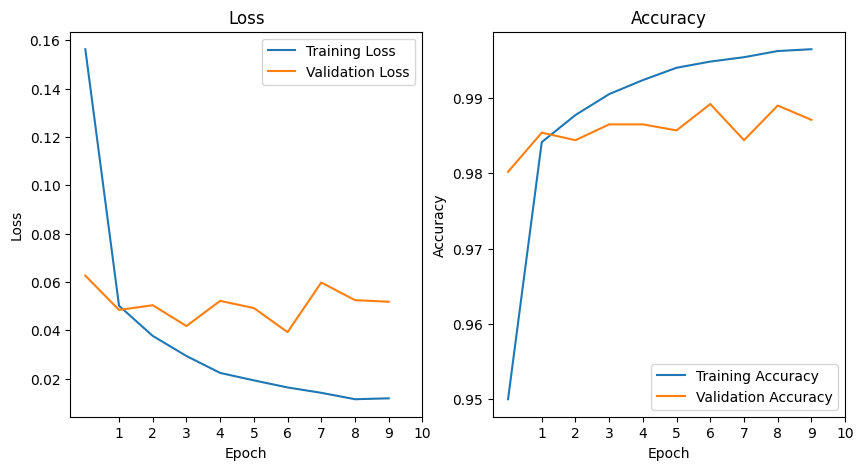

In [9]:
plot_results(results, 'first_try')

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)
**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.287208  [    0/50000]
Loss: 1.383476  [ 8000/50000]
Loss: 0.425354  [16000/50000]
Loss: 0.067607  [24000/50000]
Loss: 0.343592  [32000/50000]
Loss: 0.169728  [40000/50000]
Loss: 0.243473  [48000/50000]
Training Loss: 0.6084, Training Accuracy: 80.57%
********** Evaluation **********
 AVG Val Loss: 0.1486, Validation Accuracy: 95.46%

Epoch 2/10 
 ------------------------------
Loss: 0.021194  [    0/50000]
Loss: 0.198594  [ 8000/50000]
Loss: 0.057999  [16000/50000]
Loss: 0.208833  [24000/50000]
Loss: 0.013174 

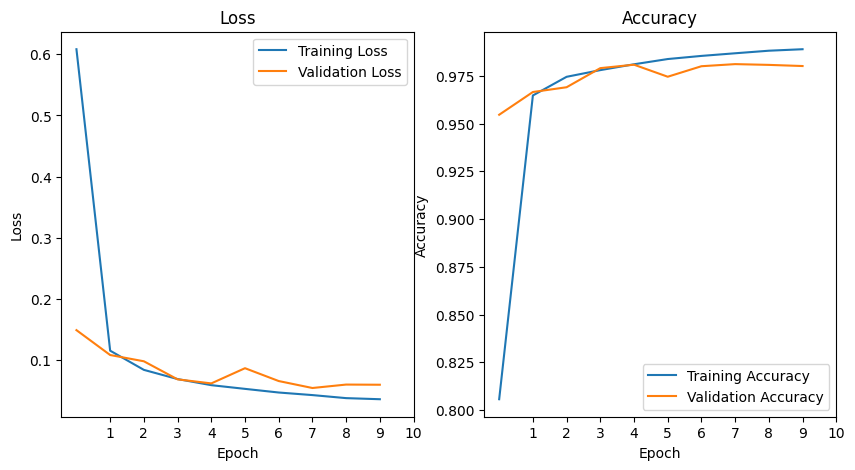

********** Testing **********
 AVG Test Loss: 0.0425, Test Accuracy: 98.58%


In [10]:
# Trying SGD with momentum

model_new = ConvNN()
model_new.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_new.parameters(), lr=0.001, momentum=0.9)
print(model_new)

results_new = training_loop(EPOCHS, optimizer, model_new, criterion, train_loader, val_loader, device)
plot_results(results_new, 'SGD_no_augmented')

test(model_new, criterion, test_loader, device)



**Question 9**: Add some data augmentations when creating the dataset for the training set.
Why do we only augment the training data? Play around with the augmentations available in
torchvision. Try to get better performance than the baseline. Once you are happy with your
choice of augmentations, run both the baseline and the augmented version on the test set
and report the accuracies in your report.

Notes:

● When we use data augmentation, using the data loaders to load the whole data into
big tensors (as we did in Question 7) creates a problem, because this means that the
transformations are only applied once per instance in the training set. Instead, we
would like to iterate multiple times over the dataset, and each time get different
transformations. You can achieve this by using the data loaders to iterate through the
data (as opposed to using the big tensors from Question 7). Make sure to create a
validation set first by applying the random_split function to the training set:

https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

○ Apply this to the dataset object before passing it to the dataloader.

In [6]:
from torchvision import datasets, transforms
import torch

def data_augmented(BATCH_SIZE: int = 16) -> tuple:

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])

    train = datasets.MNIST('MNIST_data/',
                           download=True,
                           train=True,
                           transform=transform)

    test = datasets.MNIST('MNIST_data/',
                          download=True,
                          train=False,
                          transform=transforms.ToTensor())


    train_dataset, val_dataset = random_split(train, [50000, 10000])

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader


In [12]:
trainloader, valloader, testloader = data_augmented(16)

In [13]:
model_new2 = ConvNN()
model_new2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new2.parameters(), lr=0.001, betas=(0.9, 0.999))
print(model_new2)

results_new2 = training_loop(EPOCHS, optimizer, model_new2, criterion, trainloader, valloader, device)

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)
**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.319366  [    0/50000]
Loss: 0.473577  [ 8000/50000]
Loss: 0.348148  [16000/50000]
Loss: 0.364280  [24000/50000]
Loss: 0.380980  [32000/50000]
Loss: 0.128191  [40000/50000]
Loss: 0.085864  [48000/50000]
Training Loss: 0.3271, Training Accuracy: 89.35%
********** Evaluation **********
 AVG Val Loss: 0.1492, Validation Accuracy: 95.23%

Epoch 2/10 
 ------------------------------
Loss: 0.133971  [    0/50000]
Loss: 0.010922  [ 8000/50000]
Loss: 0.011569  [16000/50000]
Loss: 0.125274  [24000/50000]
Loss: 0.196308 

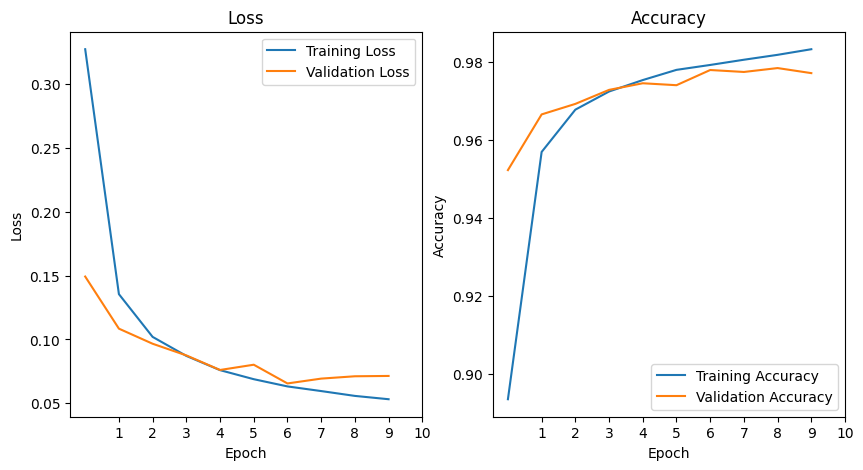

In [14]:
plot_results(results_new2, 'second_try')

In [15]:
test(model_new, criterion, testloader, device)

********** Testing **********
 AVG Test Loss: 0.0425, Test Accuracy: 98.58%


ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)
**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.313964  [    0/50000]
Loss: 2.263986  [ 8000/50000]
Loss: 0.953304  [16000/50000]
Loss: 1.036724  [24000/50000]
Loss: 0.547502  [32000/50000]
Loss: 0.435405  [40000/50000]
Loss: 0.632329  [48000/50000]
Training Loss: 1.0014, Training Accuracy: 66.68%
********** Evaluation **********
 AVG Val Loss: 0.3430, Validation Accuracy: 88.69%

Epoch 2/10 
 ------------------------------
Loss: 1.156860  [    0/50000]
Loss: 0.457666  [ 8000/50000]
Loss: 1.244746  [16000/50000]
Loss: 0.051075  [24000/50000]
Loss: 0.117383 

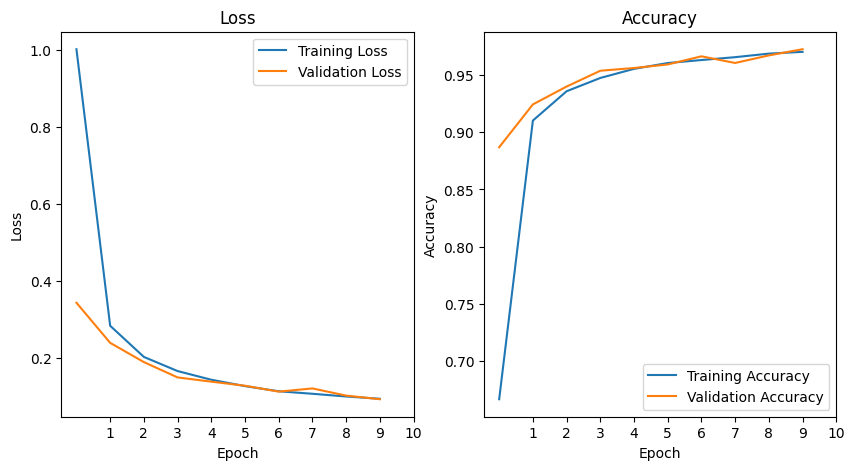

********** Testing **********
 AVG Test Loss: 0.0631, Test Accuracy: 97.91%


In [16]:
# Trying SGD with momentum

model_new3 = ConvNN()
model_new3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_new3.parameters(), lr=0.001, momentum=0.9)
print(model_new3)

results_new3 = training_loop(EPOCHS, optimizer, model_new3, criterion, trainloader, valloader, device)
plot_results(results_new3, 'SGg_augmented')

test(model_new3, criterion, testloader, device)



# Part 3: A variable-resolution classifier
In the real world, images rarely all come in the same resolution. The nice thing about the
convolutional layer is that we can apply the same kernel to images of different resolutions.

Question 10: Assume we have a convolution with a 5x5 kernel, padding 1 and stride 2, with
3 input channels and 16 output channels. We apply the convolution to an image with 3
channels and resolution 1024x768. What are the dimensions of the output tensor? What if
we apply the same convolution to an image with 3 channels and resolution 1920x1080?
Could we apply the convolution to an image with resolution 1920x1080 and 8 channels?
With this principle in hand, we can stack a series of convolutions together without worrying
about the input resolution. For each input with a different resolution, all the intermediate
tensors will have different resolutions, but the whole thing will still work.
At some point in the network, however, we need an operation that takes such a tensor of a
variable resolution and maps it to a tensor that has a fixed size, regardless of the input
dimensions. The simplest way to do this is a global pooling operation. You can think of this
as a max pool, but instead of applying the max over a patch of the image, it applies the max
over the whole of the height and width dimension, removing them from the output.


A convolution from 1024x768x3 will lead to an output dimension of 511x383x16.

The convolution over the width will follow the width of 5 over an input size of 1026 (because of the padding). With a stride of 2, this means that the filter will pass 511 times over the width (output = (input-kernel_size)+2padding)/stride + 1. With a height of 768 and a stride of 2, the filter fits 383 times over the height. Since the filter has 16 output channels, the 3 input channels will be transformed to 16 for the output.

Similarly, for an input of 1920x1018x3, the output dimensions will be 959x508x16.

Lastly, for an image with 8 channels, the convolution can take the input, but it will only consider the first 3 channels in the input. The output will be shape 1920x1018x16, but it will likely not be usable.

Question 11: Let x be an input tensor with dimensions (b, c, h, w). Write the single line of
PyTorch code that implements a global max pool and a global mean pool (one line for each
of the two poolings). The result should be a tensor with dimensions (b, c).

In [7]:
# (batch_size, input_channels, input_width, input_height)
b = 16
c = 3
h = 5
w = 5

torch.manual_seed(1)
x = torch.randn(b, c, h, w)
#print(x)

# global max pool 
max_pool = torch.nn.functional.adaptive_max_pool2d(x, (1, 1)).view(x.size(0), x.size(1))
print(max_pool)

# & global mean pool
mean_pool = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), x.size(1))
print(mean_pool.shape)

tensor([[1.6871, 2.3571, 2.0154],
        [1.9907, 2.5581, 2.2952],
        [2.5571, 1.7837, 1.9142],
        [1.7241, 2.4142, 1.1788],
        [2.3403, 1.2831, 1.6091],
        [1.8469, 1.1969, 2.2524],
        [1.8589, 1.4274, 1.4142],
        [1.2910, 1.7359, 3.0301],
        [1.3489, 2.7949, 2.5073],
        [1.4996, 1.7739, 1.7065],
        [1.7996, 1.5499, 3.3628],
        [2.8641, 1.1529, 1.9342],
        [1.4397, 1.1363, 2.7893],
        [1.7838, 3.0877, 2.2573],
        [1.6568, 1.6163, 2.0859],
        [2.3947, 2.3605, 1.6439]])
torch.Size([16, 3])


Question 12: Use an ImageFolder dataset to load the data, and pass it through the network
we used earlier. Use a Resize transform before the ToTensor transform to convert the data
to a uniform resolution of 28x28 and pass it through the network of the previous section. See
what kind of performance you can achieve.


In [11]:
import torchvision
import os

BATCH_SIZE = 64
EPOCHS = 10

# define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # convert image to grayscale
    transforms.Resize((28, 28)),  # resize images
    transforms.ToTensor()  # convert image to tensor
])

# get current working directory
current_directory = os.getcwd()

# define folder name
folder_name = 'MNIST_varres/mnist-varres/'
# construct full path to the dataset folder
data_path = os.path.join(current_directory, folder_name)

# load the ImageFolder dataset
train_dataset = datasets.ImageFolder(root=data_path + 'train/', transform=transform)
test_dataset = datasets.ImageFolder(root=data_path + 'test/', transform=transform)


varres_train, varres_test = train_dataset, test_dataset

In [12]:
model_28 = ConvNN()
model_28.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_28.parameters(), lr=0.001, betas=(0.9, 0.999))
print(model_28)


data = q7(varres_train, varres_test)

(train_loader,
val_loader,
test_loader) = data

print(train_loader)

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)


In [34]:
results = training_loop(EPOCHS, optimizer, model_28, criterion, train_loader, val_loader, device)

**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.306892  [    0/50000]
Loss: 1.142667  [ 8000/50000]
Loss: 0.303767  [16000/50000]
Loss: 0.540262  [24000/50000]
Loss: 0.488305  [32000/50000]
Loss: 0.227388  [40000/50000]
Loss: 0.737080  [48000/50000]
Training Loss: 0.6508, Training Accuracy: 79.21%
********** Evaluation **********
 AVG Val Loss: 0.3457, Validation Accuracy: 89.68%

Epoch 2/10 
 ------------------------------
Loss: 0.480995  [    0/50000]
Loss: 0.456431  [ 8000/50000]
Loss: 0.176203  [16000/50000]
Loss: 0.302259  [24000/50000]
Loss: 0.169460  [32000/50000]
Loss: 0.076791  [40000/50000]
Loss: 0.280102  [48000/50000]
Training Loss: 0.2477, Training Accuracy: 92.72%
********** Evaluation **********
 AVG Val Loss: 0.2033, Validation Accuracy: 93.83%

Epoch 3/10 
 ------------------------------
Loss: 0.072174  [    0/50000]
Loss: 0.066573  [ 8000/50000]
Loss: 0.124000  [16000/50000]
Loss: 0.246110  [24000/50000]
Loss: 0.138560  [32000

In [35]:
test(model_28, criterion, test_loader, device)

********** Testing **********
 AVG Test Loss: 0.1134, Test Accuracy: 96.95%


In [39]:
?plot_results

Signature: plot_results(results: tuple, save_fig_name: str = None, save: bool = False) -> None
Docstring:
Plots the training and validation loss and accuracy for a given model.
Args:
    results: A tuple containing the training loss, validation loss, training accuracy, and validation accuracy
    save_fig_name: The name of the figure to save. Default is None.
    save: Whether or not to save the figure. Default is False.
File:      c:\users\sergi\appdata\local\temp\ipykernel_31472\2346937490.py
Type:      function

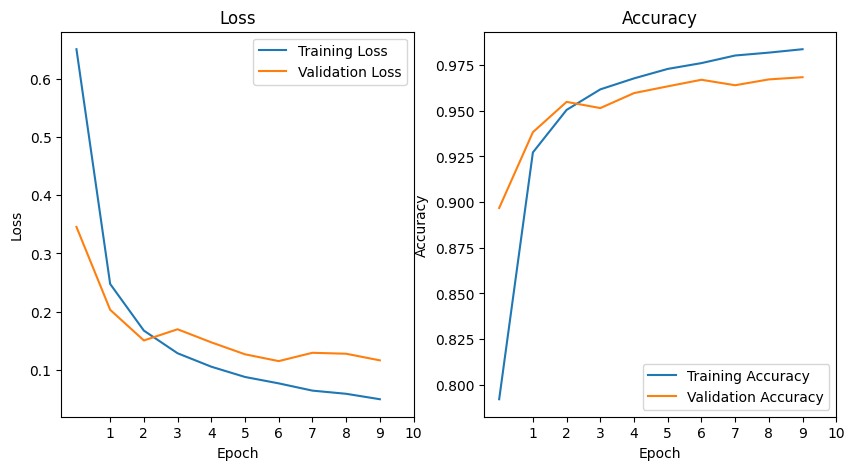

In [40]:
plot_results(results, 'resize_28')

Question 13: We could, of course, resize everything to 64x64. Apart from the fact that
running the network would be more expensive, what other downsides do you see?

A downsize of resizing everything is that information can get blown up where you don't want it to. This could also lead to warping of dimensions or features, meaning that the network is not able to train with these very important patterns as much. 

On the other hand, if input sizes are smaller, you won't gain or keep more information by adding lots of empty padding. This, combined with the fact that the network would be slower is another disadvantage.

Question 14: Load the data into a memory as three tensors: one for each resolution. Then
write a training loop with an inner loop over the three resolutions. In a more realistic
scenario, we could have a dataset where every almost every image has a unique resolution.
How would you deal with this situation?

In [24]:
import glob
from PIL import Image

res_32 = []
res_48 = []
res_64 = []

file_list = []

# Get the current working directory
current_directory = os.getcwd()

# Define the folder name
folder_name = 'MNIST_varres/mnist-varres/'

# Construct the full path to the dataset folder
data_path = os.path.join(current_directory, folder_name)


for i in range(10):
    trainpath = data_path + 'train/' + str(i) + '/'

    file_list.append(glob.glob(trainpath + "*.png"))

for i in range(10):
    # Loop over the image files
    for img_path in file_list[i]:
        # Open image using PIL
        with Image.open(img_path) as img:
            # Get the dimensions (width, height) of the image
            width, height = img.size
            if width == 32 and height == 32:
                tensor_img = torchvision.io.read_image(img_path)

                res_32.append((tensor_img, i))
            elif width == 48 and height == 48:
                tensor_img = torchvision.io.read_image(img_path)
                res_48.append((tensor_img, i))
            elif width == 64 and height == 64:
                tensor_img = torchvision.io.read_image(img_path)
                res_64.append((tensor_img, i))
            else:
                print("Error. Size of image", width, " x ", height)

tensors_32 = [t[0] for t in res_32]
tensors_48 = [t[0] for t in res_48]
tensors_64 = [t[0] for t in res_64]

labels_32 = [t[1] for t in res_32]
labels_48 = [t[1] for t in res_48]
labels_64 = [t[1] for t in res_64]

res_32_train = torch.stack(tensors_32)
res_48_train = torch.stack(tensors_48)
res_64_train = torch.stack(tensors_64)

res_32_labels = torch.tensor(labels_32)
res_48_labels = torch.tensor(labels_48)
res_64_labels = torch.tensor(labels_64)

res_32_train = torch.utils.data.TensorDataset(res_32_train, res_32_labels)
res_48_train = torch.utils.data.TensorDataset(res_48_train, res_48_labels)
res_64_train = torch.utils.data.TensorDataset(res_64_train, res_64_labels)
# res_48_train = torch.stack(torch.tensor(res_48))
# res_64_train = torch.stack(torch.tensor(res_64))

In [22]:
import imageio as iio

# repeat for test images
res_32 = []
res_48 = []
res_64 = []

file_list = []

# Get the current working directory
current_directory = os.getcwd()

# Define the folder name
folder_name = 'MNIST_varres/mnist-varres/'

# Construct the full path to the dataset folder
data_path = os.path.join(current_directory, folder_name)


for i in range(10):
    trainpath = data_path + 'test/' + str(i) + '/'

    file_list.append(glob.glob(trainpath + "*.png"))

for i in range(10):
    # Loop over the image files
    for img_path in file_list[i]:
        # Open image using PIL
        with Image.open(img_path) as img:
            # Get the dimensions (width, height) of the image
            width, height = img.size
            if width == 32 and height == 32:
                img = iio.imread(img_path)
                img_array = np.array(img)
                res_32.append((torch.tensor(img_array), i))
                #tensor_img = torchvision.io.read_image(img_path)
                #res_32.append((tensor_img, torch.tensor(i)))
            elif width == 48 and height == 48:
                tensor_img = torchvision.io.read_image(img_path)
                img_array = np.array(img)
                res_48.append((torch.tensor(img_array), i))
            elif width == 64 and height == 64:
                tensor_img = torchvision.io.read_image(img_path)
                img_array = np.array(img)
                res_64.append((torch.tensor(img_array), i))
            else:
                print("Error. Size of image", width, " x ", height)

#res_32_images = zip(*res_32)

tensors_32 = [t[0] for t in res_32]
tensors_48 = [t[0] for t in res_48]
tensors_64 = [t[0] for t in res_64]

labels_32 = [t[1] for t in res_32]
labels_48 = [t[1] for t in res_48]
labels_64 = [t[1] for t in res_64]

res_32_test = torch.stack(tensors_32)
res_48_test = torch.stack(tensors_48)
res_64_test = torch.stack(tensors_64)

res_32_labels = torch.tensor(labels_32)
res_48_labels = torch.tensor(labels_48)
res_64_labels = torch.tensor(labels_64)

res_32_test = torch.utils.data.TensorDataset(res_32_test, res_32_labels)
res_48_test = torch.utils.data.TensorDataset(res_48_test, res_48_labels)
res_64_test = torch.utils.data.TensorDataset(res_64_test, res_64_labels)

# res_32_test = torch.stack(res_32)
# res_48_test = torch.stack(res_48)
# res_64_test = torch.stack(res_64)

C:\Users\sergi\AppData\Local\Temp\ipykernel_19180\1979764308.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(img_path)


In [42]:




def loader_variable(train_data: torch.utils.data.Dataset, test_data: torch.utils.data.Dataset):
    
    # Split the training data into training and validation sets
    trainlen = round((5/6) * len(train_data))
    vallen = round(len(train_data)/6)
    
    # correct for mistaken rounding
    if trainlen + vallen < len(train_data):
        vallen += 1
    
    train_data, val_data = random_split(train_data, [trainlen, vallen])

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=2)
    return train_loader, val_loader, test_loader

def training_loop_variable(n_epochs: int,
                model: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 loss_function: torch.nn.Module,
                 train_loader: dict,
                 val_loader: dict,
                 device: torch.device):
    # print(f'{str("*"*10)}STARTING TRAINING{str("*"*10)}')
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    model = model.to(device)
    
    # train_loss_dict = {}
    # train_acc_dict  = {}
    # val_loss_dict   = {}
    # val_acc_dict    = {}

    loss_function = loss_function.to(device)


    # for k, v in train_loader_dict.items():
    #     # print(f'{str("*"*10)}STARTING TRAINING WITH TRAINLOADER {k} {str("*"*10)}')

    #     model_var = ConvNN_VAR() # create new model for each trainloader, otherwise previous parameters are used
    #     model_var.to(device)
    #     # print(model_var)
    
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs} \n {'-'*30}")
        
        running_acc = 0.0
        running_loss = 0.0
        total_samples = 0
        model.train()

        # print(train_loader)
        # for batch in train_loader:
        #     data, labels = batch  # Unpack the batch
        #     # print(data.shape)  # Check the shape of the data
        #     # print(labels.shape)  # Check the shape of the labels
        #     break  # Stop after printing the first batch for inspection
        for batch, (images, labels) in enumerate(train_loader):
            # images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            images = images.float()
            output = model_var(images)
            loss = loss_function(output, labels)
            running_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy training
            running_acc += (output.argmax(1) == labels).sum().item()
            total_samples += labels.shape[0]

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(images)
                print(f"Loss: {loss:>7f}  [{current:>5d}/{len(train_loader.dataset):>5d}]")


        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / total_samples
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        
        # train_loss_dict[k] = running_loss / len(train_loader)
        # train_acc_dict[k] = running_acc / total_samples

        # print(f"Training Loss: {train_loss_dict[k]:.4f}, Training Accuracy: {train_acc_dict[k]*100:.2f}%")
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc*100:.2f}%")

        running_acc = 0.0
        running_loss = 0.0
        total_samples = 0
        print(f"{'*'*10} Evaluation {'*'*10}")
        model.eval()
        with torch.no_grad():
            # val_loader = val_loader_dict[k]
            for images, labels in val_loader:
                # images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                images = images.float()
                output = model_var(images)
                loss = loss_function(output, labels)

                running_loss += loss.item()
                running_acc += (output.argmax(1) == labels).sum().item()
                total_samples += labels.shape[0]

            epoch_loss = running_loss / len(val_loader)
            epoch_acc = running_acc / total_samples
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)

            # val_loss_dict[k] = running_loss / len(val_loader)
            # val_acc_dict[k] = running_acc / total_samples

            # print(f" AVG Val Loss: {val_loss_dict[k]:.4f}, Validation Accuracy: {val_acc_dict[k]*100:.2f}%")
            print(f" AVG Val Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_acc*100:.2f}%")
            print()

    print(f"Finished Training")
    print()

    return (train_loss, val_loss, train_acc, val_acc)

In [43]:
data_32 = loader_variable(res_32_train, res_32_test)

(train_loader_32,
val_loader_32,
test_loader_32) = data_32

data_48 = loader_variable(res_48_train, res_48_test)

(train_loader_48,
val_loader_48,
test_loader_48) = data_48

data_64 = loader_variable(res_64_train, res_64_test)

(train_loader_64,
val_loader_64,
test_loader_64) = data_64

train_loader_dict = {'32': train_loader_32, '48': train_loader_48, '64': train_loader_64}
val_loader_dict = {'32': val_loader_32, '48': val_loader_48, '64': val_loader_64}

In [45]:
# construct the network
class ConvNN_VAR(nn.Module):
    def __init__(self):
        super(ConvNN_VAR, self).__init__()
        
        # self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # Changed from 16 to 32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))
        # self.linear_layer = nn.Linear(64 * 4 * 4, 10)
        self.linear_layer = nn.Linear(64 * 2 * 2, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.global_pool(F.relu(self.conv1(x)))
        x = self.global_pool(F.relu(self.conv2(x)))
        x = self.global_pool(F.relu(self.conv3(x)))
        # print(f'x shape: {x.shape}')
        # x = x.view(-1, 64 * 3 * 3)
        x = x.view(-1, 64 * 2 * 2)
        x = self.linear_layer(x)
        return x


model_var = ConvNN_VAR()
print(model_var) # only to print the model, inside training_loop_variable it is created again
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_var.parameters(), lr=0.001, betas=(0.9, 0.999))


train_loss_dict = {}
train_acc_dict  = {}
val_loss_dict   = {}
val_acc_dict    = {}

for name, train_loader in train_loader_dict.items():
    print(f'{str("*"*10)}STARTING TRAINING WITH TRAINLOADER {name} {str("*"*10)}')
    model_var = ConvNN_VAR() # create new model for each trainloader, otherwise previous parameters are used
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model_var.parameters(), lr=0.001, betas=(0.9, 0.999))
    val_loader = val_loader_dict[name]
    results_var = training_loop_variable(EPOCHS, model_var, optimizer, criterion, train_loader, val_loader_dict[name], device)
    train_loss_dict[name], val_loss_dict[name], train_acc_dict[name], val_acc_dict[name] = results_var

ConvNN_VAR(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (global_pool): AdaptiveAvgPool2d(output_size=(2, 2))
  (linear_layer): Linear(in_features=256, out_features=10, bias=True)
)
**********STARTING TRAINING WITH TRAINLOADER 32 **********
Epoch 1/10 
 ------------------------------
Loss: 2.115931  [    0/16594]
Loss: 1.219395  [ 1600/16594]
Loss: 0.518979  [ 3200/16594]
Loss: 0.781099  [ 4800/16594]
Loss: 0.473121  [ 6400/16594]
Loss: 0.495997  [ 8000/16594]
Loss: 0.471115  [ 9600/16594]
Loss: 0.288624  [11200/16594]
Loss: 0.554437  [12800/16594]
Loss: 1.054351  [14400/16594]
Loss: 0.733428  [16000/16594]
Training Loss: 0.6774, Training Accuracy: 76.97%
********** Evaluation **********
 AVG Val Loss: 0.3487, Validation Accuracy: 88.76%

Epoch 2/10 
 ------------------------------
Loss: 0.411490  [   

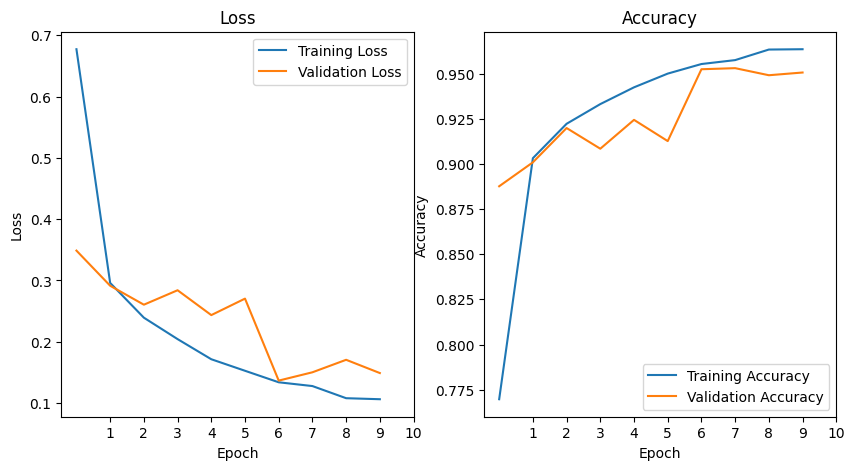

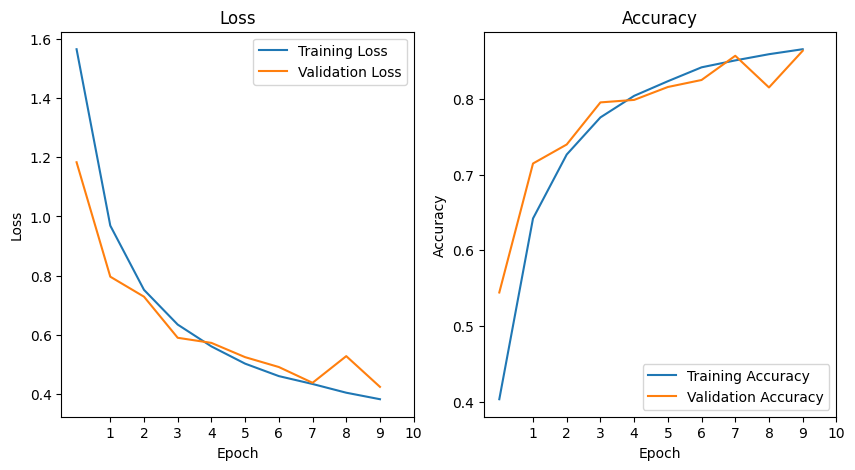

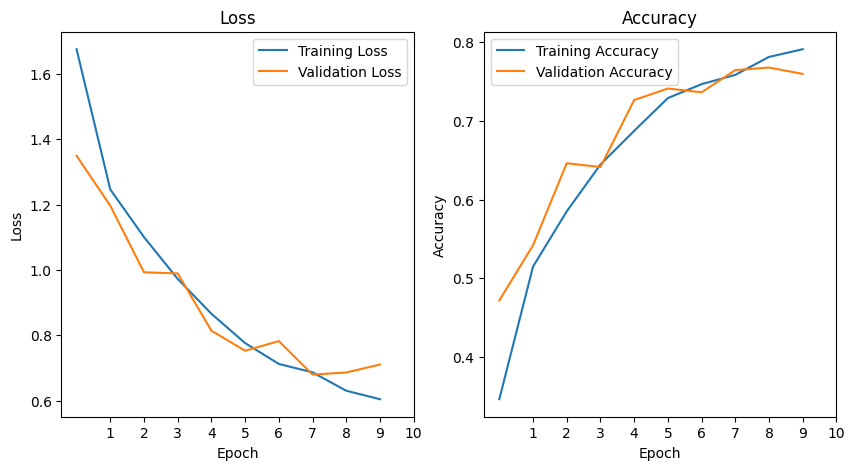

In [47]:
results_32 = (train_loss_dict['32'], val_loss_dict['32'], train_acc_dict['32'], val_acc_dict['32'])
results_48 = (train_loss_dict['48'], val_loss_dict['48'], train_acc_dict['48'], val_acc_dict['48'])
results_64 = (train_loss_dict['64'], val_loss_dict['64'], train_acc_dict['64'], val_acc_dict['64'])
plot_results(results_32, '32', save=True)
plot_results(results_48, '48', save=True)
plot_results(results_64, '64', save=True)

When working with images with variable data size, I would resize all images to a mode standard size, or sort images from small to large and use that as network input order. Depending on the data, you could also take multiple crops out of a larger image to provide more training data for non-centered input.

Question 15: Note that if we set N=64, as we did for the fixed resolution network the last
linear layer has fewer parameters here than it did in the first one. Either by trial and error, or
through computing the parameters, find the value of N for which both networks have roughly
the same number of parameters (this will allow us to fairly compare their performances).

In [78]:
### my code here
for param in model_var.parameters():
    print(type(param), param.size())
    
print(' ')
    
for param in model_28.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([32, 1, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 16, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 32, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])
 
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 1, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 16, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 32, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 576])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


Question 16: Compare the validation performance of global max pooling to that of global
mean pooling. Report your findings, and choose a global pooling variant.


In [48]:
### GLOBAL MAX POOL
class ConvNN_MAX(nn.Module):
    def __init__(self):
        super(ConvNN_MAX, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveMaxPool2d((1, 1))
        self.linear_layer = nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # Applying global max pooling
        x = x.view(-1, 64)  # Reshaping for linear layer input size
        x = self.linear_layer(x)
        return x

# model_max = ConvNN()
# model_max.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_max.parameters(), lr=0.001, betas=(0.9, 0.999))
# print(model_max)

# data = q7(train, test)  # using data from question 7

# (train_loader,
# val_loader,
# test_loader) = data

# results = training_loop(EPOCHS, optimizer, model_max, criterion, train_loader, val_loader, device)

# test(model_max, criterion, test_loader, device)

# plot_results(results, 'global_max_pool')
model_var = ConvNN_MAX()
print(model_var) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_var.parameters(), lr=0.001, betas=(0.9, 0.999))


train_loss_dict = {}
train_acc_dict  = {}
val_loss_dict   = {}
val_acc_dict    = {}

for name, train_loader in train_loader_dict.items():
    print(f'{str("*"*10)}STARTING TRAINING WITH TRAINLOADER {name} {str("*"*10)}')
    model_var = ConvNN_MAX() # create new model for each trainloader, otherwise previous parameters are used
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model_var.parameters(), lr=0.001, betas=(0.9, 0.999))
    val_loader = val_loader_dict[name]
    results_var = training_loop_variable(EPOCHS, model_var, optimizer, criterion, train_loader, val_loader_dict[name], device)
    train_loss_dict[name], val_loss_dict[name], train_acc_dict[name], val_acc_dict[name] = results_var

ConvNN_MAX(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (linear_layer): Linear(in_features=64, out_features=10, bias=True)
)
**********STARTING TRAINING WITH TRAINLOADER 32 **********
Epoch 1/10 
 ------------------------------
Loss: 11.560261  [    0/16594]
Loss: 1.209254  [ 1600/16594]
Loss: 0.727897  [ 3200/16594]
Loss: 0.834310  [ 4800/16594]
Loss: 0.193507  [ 6400/16594]
Loss: 0.410090  [ 8000/16594]
Loss: 0.302331  [ 9600/16594]
Loss: 0.789870  [11200/16594]
Loss: 0.501668  [12800/16594]
Loss: 0.434289  [14400/16594]
Loss: 0.078496  [16000/16594]
Training Loss: 0.7771, Training Accuracy: 77.86%
********** Evaluation **********
 AVG Val Loss: 0.3393, Validation Accuracy: 88.70%

Epoch 2/10 
 ------------------------------
Loss: 0.046650  [    0/1659

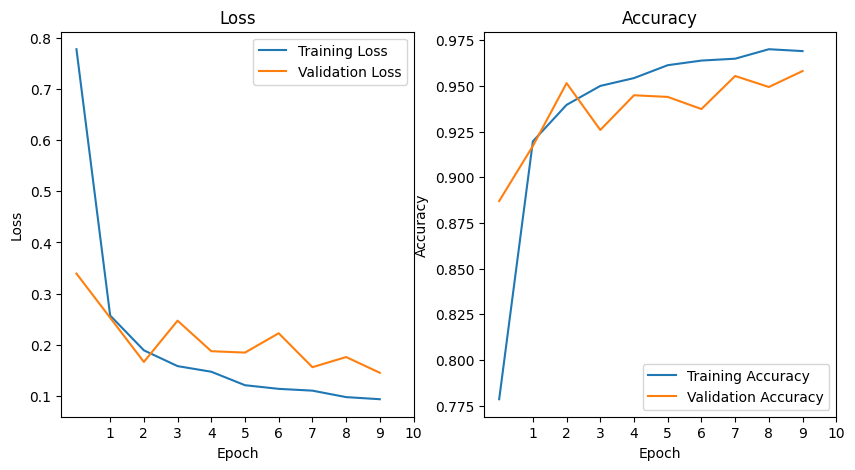

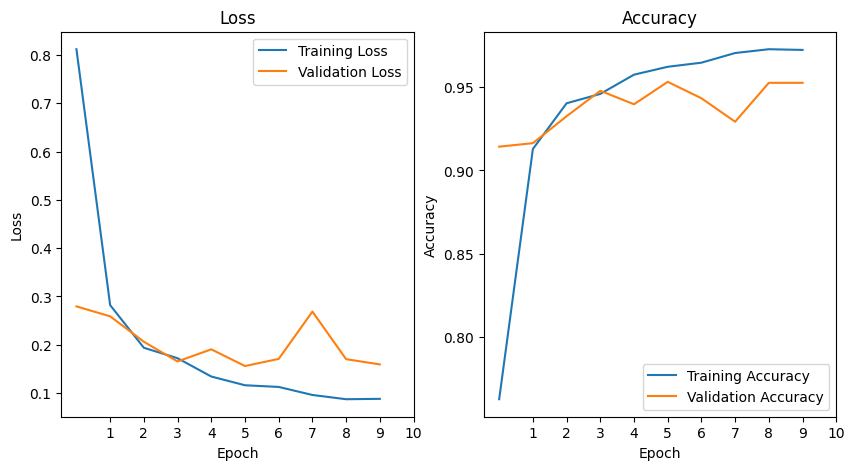

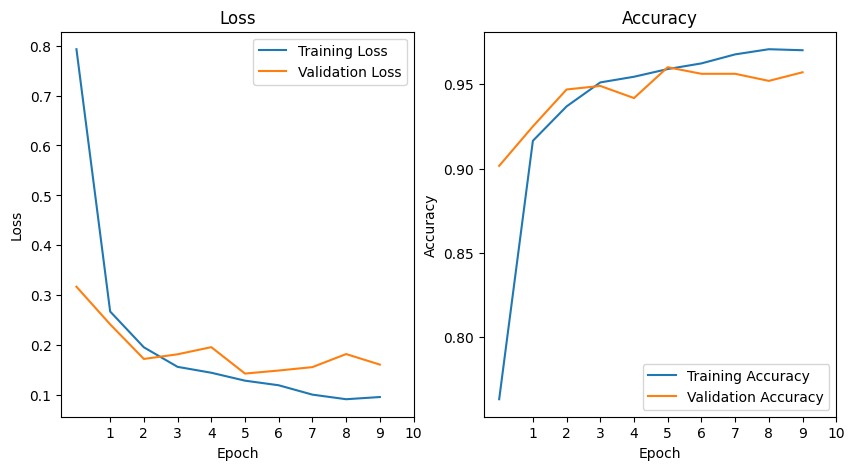

In [49]:
results_32 = (train_loss_dict['32'], val_loss_dict['32'], train_acc_dict['32'], val_acc_dict['32'])
results_48 = (train_loss_dict['48'], val_loss_dict['48'], train_acc_dict['48'], val_acc_dict['48'])
results_64 = (train_loss_dict['64'], val_loss_dict['64'], train_acc_dict['64'], val_acc_dict['64'])
plot_results(results_32, '32_globalMAX', save=True)
plot_results(results_48, '48_globalMAX', save=True)
plot_results(results_64, '64_globalMAX', save=True)

ConvNN_MEAN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (linear_layer): Linear(in_features=64, out_features=10, bias=True)
)
**********STARTING TRAINING WITH TRAINLOADER 32 **********
Epoch 1/10 
 ------------------------------
Loss: 2.312494  [    0/16594]
Loss: 2.286918  [ 1600/16594]
Loss: 1.950240  [ 3200/16594]
Loss: 1.358830  [ 4800/16594]
Loss: 1.542904  [ 6400/16594]
Loss: 1.946204  [ 8000/16594]
Loss: 1.570337  [ 9600/16594]
Loss: 1.759458  [11200/16594]
Loss: 1.868853  [12800/16594]
Loss: 1.974577  [14400/16594]
Loss: 1.633012  [16000/16594]
Training Loss: 1.7996, Training Accuracy: 29.82%
********** Evaluation **********
 AVG Val Loss: 1.6462, Validation Accuracy: 37.00%

Epoch 2/10 
 ------------------------------
Loss: 1.851163  [    0/1659

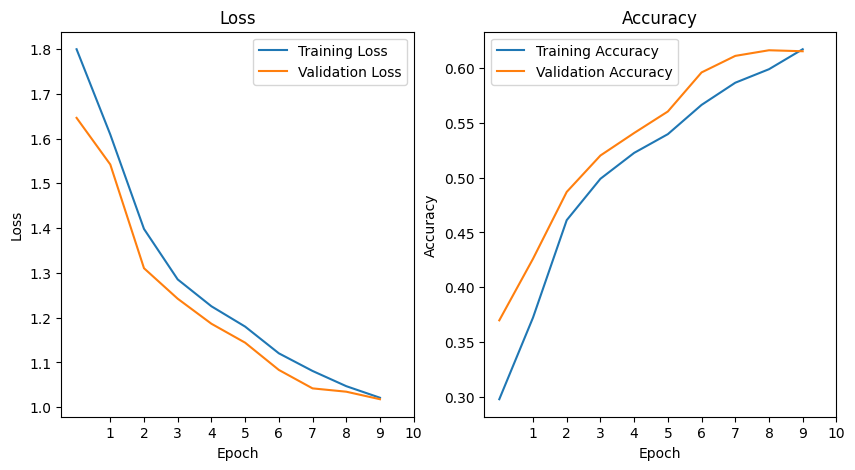

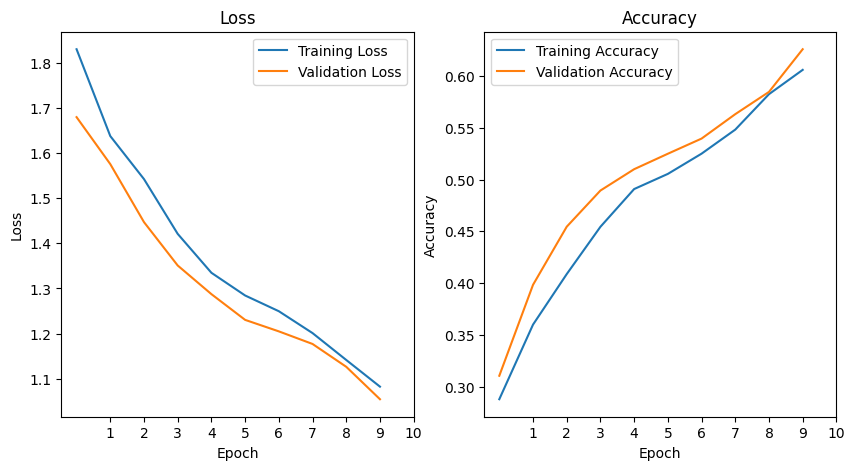

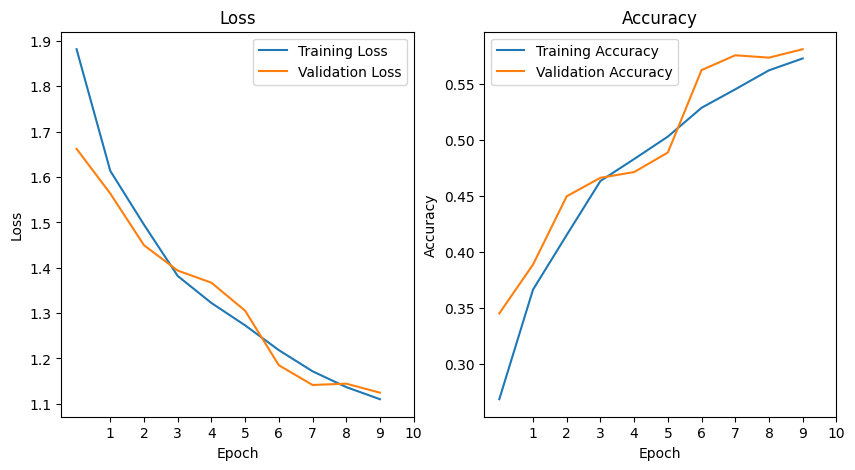

In [50]:
# GLOBAL MEAN POOL
class ConvNN_MEAN(nn.Module):
    def __init__(self):
        super(ConvNN_MEAN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear_layer = nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64)
        x = self.linear_layer(x)
        return x

model_var = ConvNN_MEAN()
print(model_var) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_var.parameters(), lr=0.001, betas=(0.9, 0.999))


train_loss_dict = {}
train_acc_dict  = {}
val_loss_dict   = {}
val_acc_dict    = {}

for name, train_loader in train_loader_dict.items():
    print(f'{str("*"*10)}STARTING TRAINING WITH TRAINLOADER {name} {str("*"*10)}')
    model_var = ConvNN_MEAN() # create new model for each trainloader, otherwise previous parameters are used
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model_var.parameters(), lr=0.001, betas=(0.9, 0.999))
    val_loader = val_loader_dict[name]
    results_var = training_loop_variable(EPOCHS, model_var, optimizer, criterion, train_loader, val_loader_dict[name], device)
    train_loss_dict[name], val_loss_dict[name], train_acc_dict[name], val_acc_dict[name] = results_var

results_32 = (train_loss_dict['32'], val_loss_dict['32'], train_acc_dict['32'], val_acc_dict['32'])
results_48 = (train_loss_dict['48'], val_loss_dict['48'], train_acc_dict['48'], val_acc_dict['48'])
results_64 = (train_loss_dict['64'], val_loss_dict['64'], train_acc_dict['64'], val_acc_dict['64'])
plot_results(results_32, '32_globalMEAN', save=True)
plot_results(results_48, '48_globalMEAN', save=True)
plot_results(results_64, '64_globalMEAN', save=True)

Question 17: Tune the variable resolution network and the fixed resolution network from
question 12 and then compare the test set performance of both. Report your findings.

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)
**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.300792  [    0/50000]
Loss: 0.959901  [ 8000/50000]
Loss: 0.653133  [16000/50000]
Loss: 1.084840  [24000/50000]
Loss: 0.358088  [32000/50000]
Loss: 0.085729  [40000/50000]
Loss: 0.205225  [48000/50000]
Training Loss: 0.6315, Training Accuracy: 79.59%
********** Evaluation **********
 AVG Val Loss: 0.3352, Validation Accuracy: 89.64%

Epoch 2/10 
 ------------------------------
Loss: 0.207774  [    0/50000]
Loss: 0.113410  [ 8000/50000]
Loss: 0.302285  [16000/50000]
Loss: 0.160261  [24000/50000]
Loss: 0.122505 

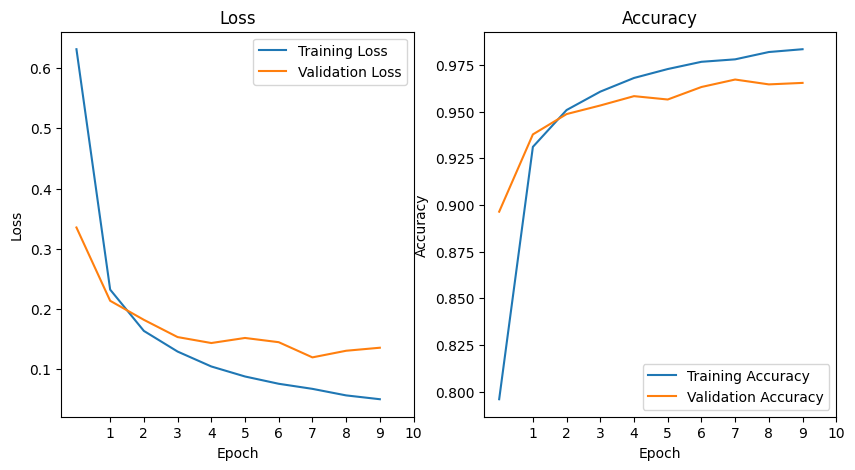

In [53]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_layer = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = self.linear_layer(x)
        return x

BATCH_SIZE = 32
EPOCHS = 10

model_28_tune = ConvNN()
model_28_tune.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_28_tune.parameters(), lr=0.001, betas=(0.9, 0.999))
print(model_28_tune)

data = q7(varres_train, varres_test)

(train_loader,
val_loader,
test_loader) = data

print(train_loader)

results = training_loop(EPOCHS, optimizer, model_28_tune, criterion, train_loader, val_loader, device)

test(model_28_tune, criterion, test_loader, device)

plot_results(results, 'resize_28_tuned')

In [64]:
# load data as three tensors
# define transformations
from torchvision.utils import save_image
transform_32 = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images
    transforms.ToTensor()  # Convert image to tensor
])

transform_48 = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize images
    transforms.ToTensor()  # Convert image to tensor
])

transform_64 = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.ToTensor()  # Convert image to tensor
])

train_32 = datasets.MNIST('MNIST_varres/',
                       download=True,
                       train=True,
                       transform=transform_32)
train_48 = datasets.MNIST('MNIST_varres/',
                       download=True,
                       train=True,
                       transform=transform_48)
train_64 = datasets.MNIST('MNIST_varres/',
                       download=True,
                       train=True,
                       transform=transform_64)

test_32 = datasets.MNIST('MNIST_varres/',
                    download=True,
                    train=False,
                    transform=transform_32)
test_48 = datasets.MNIST('MNIST_varres/',
                    download=True,
                    train=False,
                    transform=transform_48)
test_64 = datasets.MNIST('MNIST_varres/',
                    download=True,
                    train=False,
                    transform=transform_64)

# TAKES TOO LONG !!! At least 30 minutes on my Laptop !!

# def save_dataset_as_images(dataset, directory):
#     os.makedirs(directory, exist_ok=True)

#     # create directory for each label
#     for i in range(10):
#         os.makedirs(os.path.join(directory, str(i)), exist_ok=True)

#     # save images in the corresponding directory for each label
#     for i, (img, label) in enumerate(dataset):
#         save_image(img, os.path.join(directory, str(label), f'{str(i).zfill(5)}.png'))

# save_dataset_as_images(train_32, 'MNIST_varres/images/train_32')
# save_dataset_as_images(train_48, 'MNIST_varres/images/train_48')
# save_dataset_as_images(train_64, 'MNIST_varres/images/train_64')

# save_dataset_as_images(test_32, 'MNIST_varres/images/test_32')
# save_dataset_as_images(test_48, 'MNIST_varres/images/test_48')
# save_dataset_as_images(test_64, 'MNIST_varres/images/test_64')

In [65]:
# import os
# import glob

# for resolution in [32, 48, 64]:
#     # Define the data path for the current resolution
#     data_path = os.path.join('/content/mnist-varres/train', str(resolution))
#     print(f'Data path: {data_path}')

#     # Use glob to get a list of all image files in the current resolution
#     file_paths = glob.glob(os.path.join(data_path, '*.png'))
#     print(f'File paths: {file_paths}')